In [1]:
'''TensorFlow implementation of http://arxiv.org/pdf/1312.6114v10.pdf'''

from __future__ import absolute_import, division, print_function

import math
import os
import glob
import numpy as np
import scipy.misc
import tensorflow as tf
import scipy.io as spio
from tensorflow.contrib import layers
from tensorflow.contrib import losses
from tensorflow.contrib.framework import arg_scope
from scipy.misc import imsave
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet

#from progressbar import ETA, Bar, Percentage, ProgressBar
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from keras.datasets import cifar10
#from vae import VAE
#from gan import GAN

flags = tf.flags
logging = tf.logging

flags.DEFINE_integer("batch_size", 128, "batch size")
flags.DEFINE_integer("updates_per_epoch", 1000, "number of updates per epoch")
flags.DEFINE_integer("max_epoch", 1000, "max epoch")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
flags.DEFINE_string("working_directory", "./", "")
flags.DEFINE_integer("hidden_size", 128, "size of the hidden VAE unit")
flags.DEFINE_string("model", "vae", "gan or vae")
flags.DEFINE_string("generate_size", 3000, "batch size of generated images")

FLAGS = flags.FLAGS

batch_size = 128
num_classes = 2
epochs = 50

# data_directory = os.path.join(FLAGS.working_directory, "MNIST")
# if not os.path.exists(data_directory):
#     os.makedirs(data_directory)
# mnist_all = input_data.read_data_sets(data_directory, one_hot=False, validation_size = 0)

# mnist_train_images = mnist_all.train.images
# mnist_train_labels = mnist_all.train.labels
# mnist_test_images = mnist_all.test.images
# mnist_test_labels = mnist_all.test.labels

# print(mnist_test_labels)
##########################load affNIST data########################

# train_data=np.array([])
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        


def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
# for i, xi in enumerate(glob.glob(os.path.join('affNIST',"*.mat"))):
# #     print(i)
# #     print(xi)
#     n=i+1
#     xii = sio.loadmat(xi)
#     #print(xii)
#     #print(xii['affNISTdata'])
#     xn = xii['affNISTdata']['image']#.transpose()
#     print(xn.shape)
#     yn = xii['affNISTdata']['label_int']
#     print(yn.shape)
    
#     if n==1:
#         x_train = xn
#         y_train = yn
#     else:
#         x_train = np.append(x_train,xn,axis=0)
#         y_train = np.append(y_train,yn,axis=0)


dataset = loadmat('affNIST/1.mat')
y_train = dataset['affNISTdata']['label_int']
x_train = dataset['affNISTdata']['image'].transpose()

for i in range(31):
    dataset1 = loadmat('affNIST/' + str(i+2) + '.mat')
    y_train1 = dataset1['affNISTdata']['label_int']
    x_train1 = dataset1['affNISTdata']['image'].transpose()

    x_train = np.vstack((x_train, x_train1))
    y_train = np.hstack((y_train, y_train1))
   
print(x_train.shape)
print(y_train.shape)

 # x_train = train_data[:][0]
# y_train = train_data[:][1]




test_data = loadmat('test.mat')
x_test = test_data['affNISTdata']['image'].transpose()
y_test = test_data['affNISTdata']['label_int']







# (x_train,y_train),(x_test,y_test)=cifar10.load_data()
# x_train = np.reshape(x_train,(50000,-1))
# # x_test = np.reshape(x_test,(10000,-1))
refined_label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_train_per_label = [384, 5000, 384, 5000, 384, 5000, 384, 5000, 384, 5000]
train_refined_label_idx = np.array([], dtype = np.uint8)
test_refined_label_idx = np.array([], dtype = np.uint8)
for idx, label_value in enumerate(refined_label):
    refined_one_label_idx = np.where( y_train == label_value )[0][:num_train_per_label[idx]]
    train_refined_label_idx = np.append( train_refined_label_idx,  refined_one_label_idx)
x = x_train[train_refined_label_idx, :]
y = y_train[train_refined_label_idx]


# num_test_per_label = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
# test_refined_label_idx = np.array([], dtype = np.uint8)
# for idx, label_value in enumerate(refined_label):
#     refined_one_label_idx = np.where( mnist_test_labels == label_value )[0][:num_test_per_label[idx]]
#     test_refined_label_idx = np.append( test_refined_label_idx,  refined_one_label_idx)
    
# x_test = mnist_test_images 
# y_test = mnist_test_labels 
#print('original dataset shape{}'.format(Counter(y)))
print('x_test shape and type:', x_test.shape, type(x_test))
print('y_test shape and type:', y_test.shape, type(y_test))


xminor=np.array([])
yminor=np.array([])
minor_label = np.array([0,2,4,6,8])
for n,nl in enumerate(minor_label):
    ###########Get generated lable 0 samples by using SMOTE######################
    xx=np.copy(x);  
    yy=np.copy(y);  
    for i, yi in enumerate(yy):
        if yi!=nl:
            yy[i]=1
     
    sm = SMOTE(ratio=0.18842,k_neighbors=200,random_state=42,kind='regular')
    xc,yc = sm.fit_sample(xx,yy)
    print('new dataset shape{}'.format(Counter(yc)))
    refined_label = [nl]
    train_label0_idx = np.array([], dtype = np.uint8)
    for idx, label_value in enumerate(refined_label):
        refined_one_label_idx = np.where( yc == label_value )[0][:]
        train_label0_idx = np.append( train_label0_idx,  refined_one_label_idx)
    if n==0:
        xminor=xc[train_label0_idx, :]
        yminor=yc[train_label0_idx]
    else:
        xminor = np.append(xminor,xc[train_label0_idx, :],axis=0)
        yminor = np.append(yminor,yc[train_label0_idx],axis=0)
print('xminor.shape:',xminor.shape)
print('yminor.shape:',yminor.shape)

Using TensorFlow backend.


(1600000, 1600)
(1600000,)
x_test shape and type: (320000, 1600) <type 'numpy.ndarray'>
y_test shape and type: (320000,) <type 'numpy.ndarray'>
new dataset shapeCounter({1: 26536, 0: 4999})
new dataset shapeCounter({1: 26536, 2: 4999})
new dataset shapeCounter({1: 26536, 4: 4999})
new dataset shapeCounter({1: 26536, 6: 4999})
new dataset shapeCounter({1: 26536, 8: 4999})
xminor.shape: (24995, 1600)
yminor.shape: (24995,)


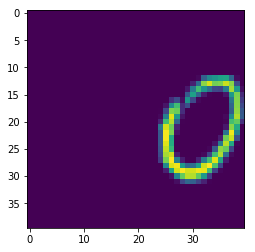

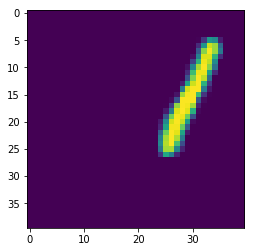

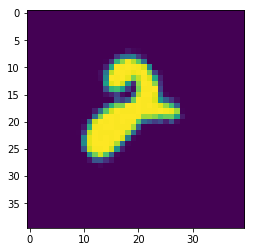

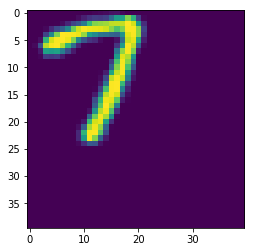

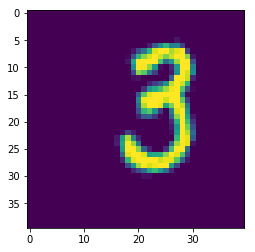

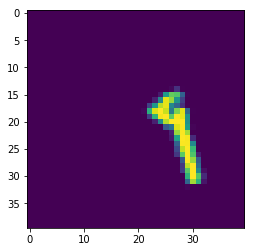

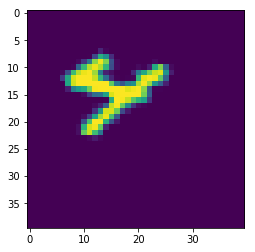

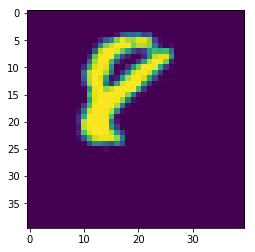

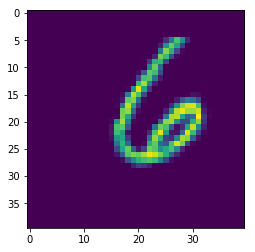

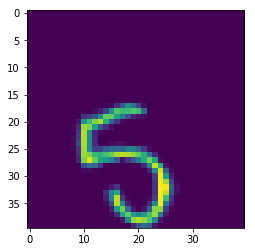

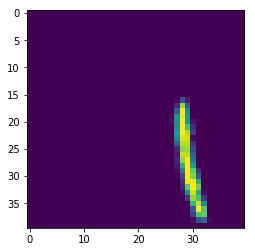

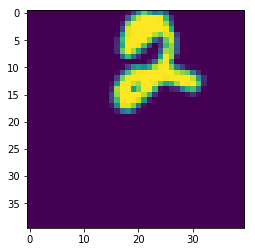

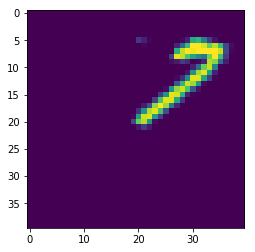

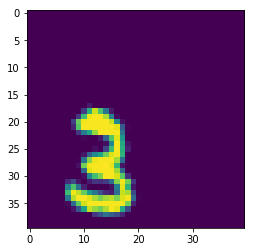

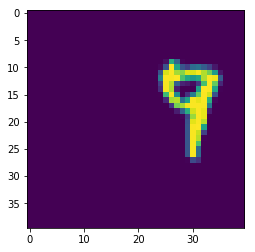

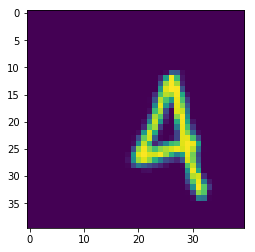

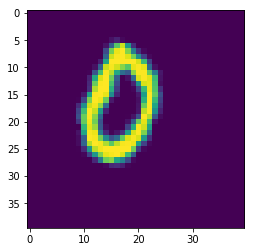

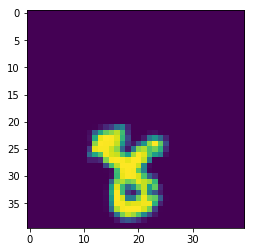

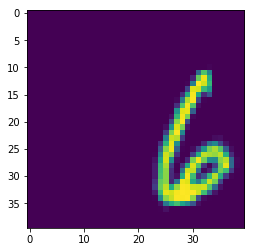

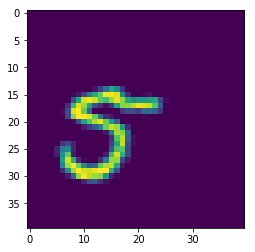

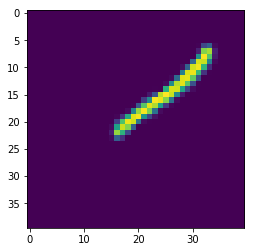

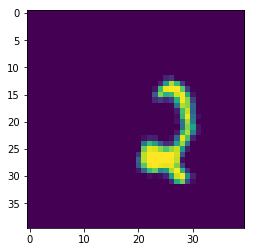

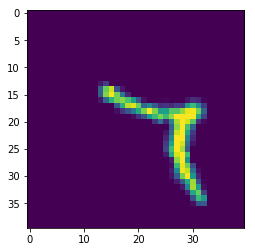

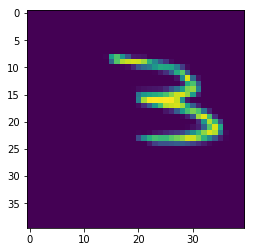

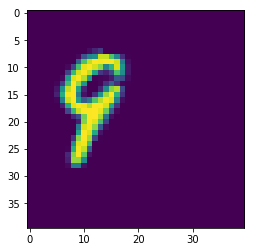

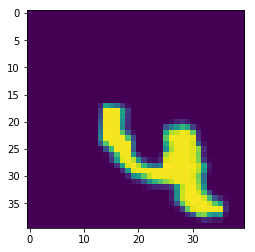

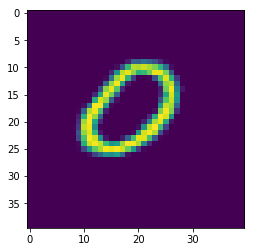

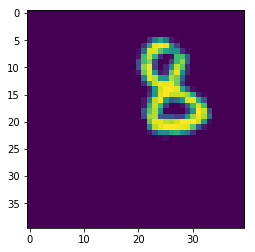

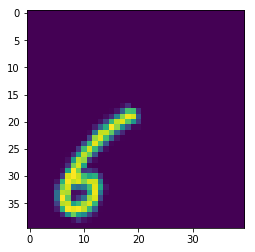

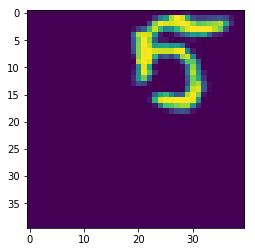

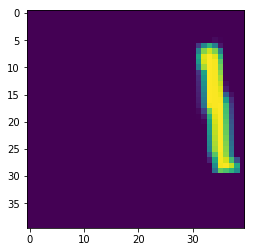

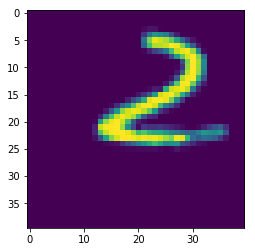

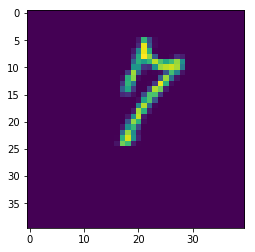

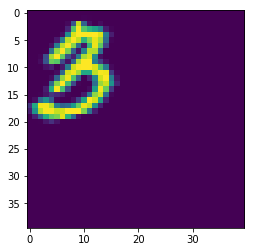

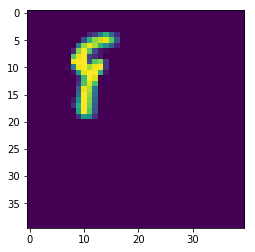

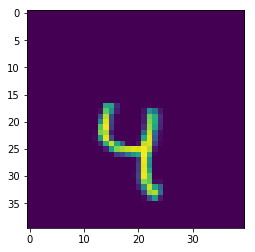

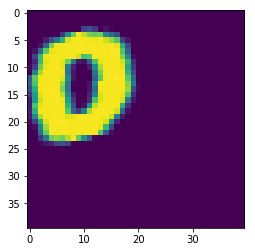

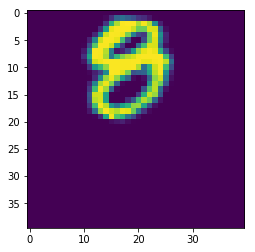

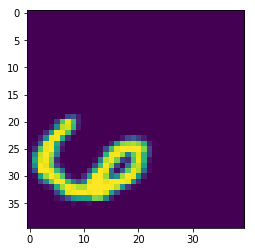

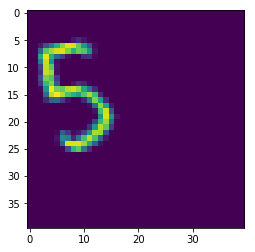

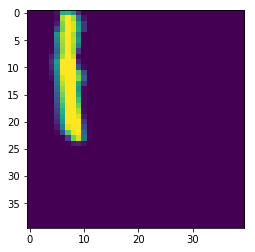

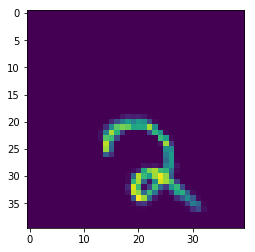

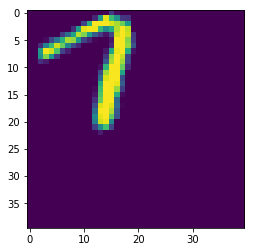

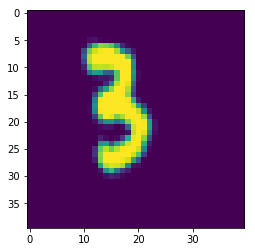

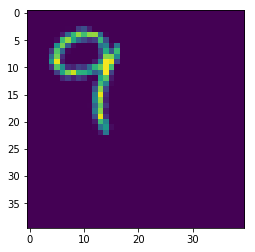

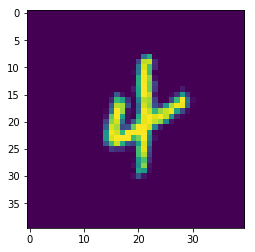

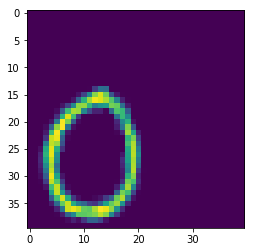

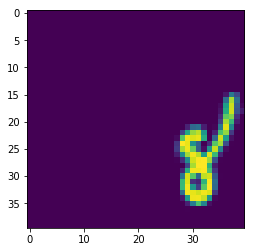

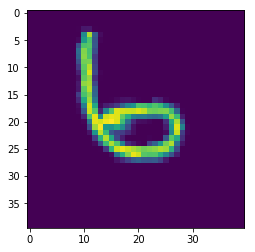

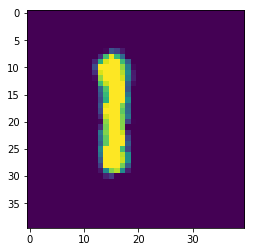

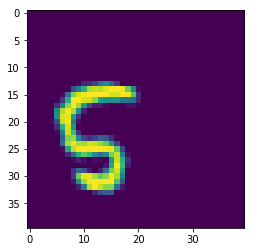

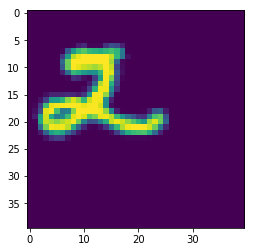

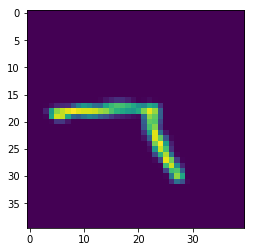

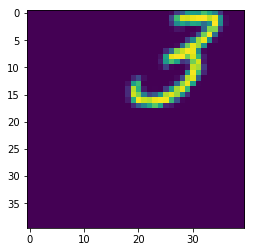

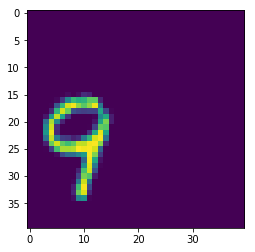

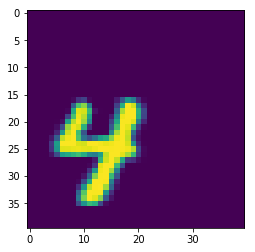

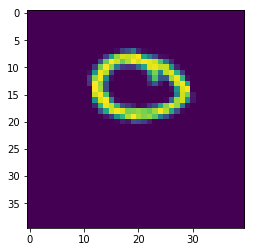

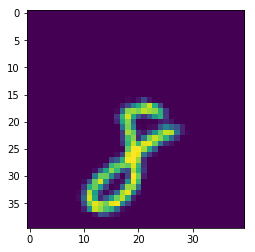

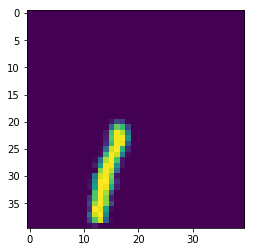

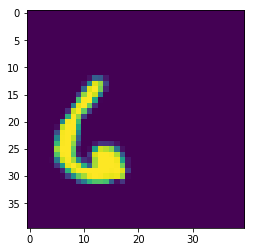

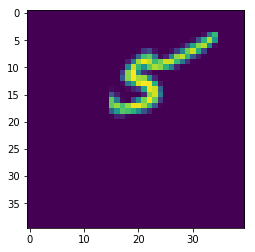

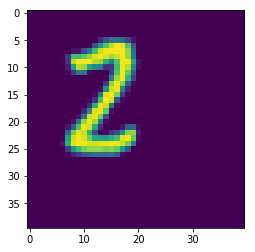

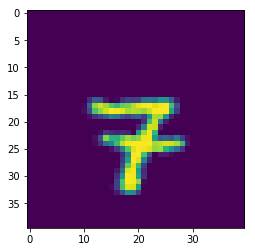

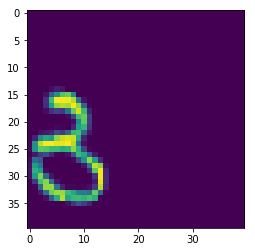

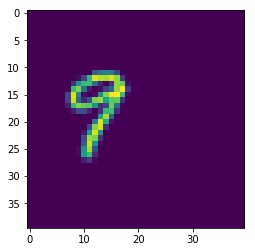

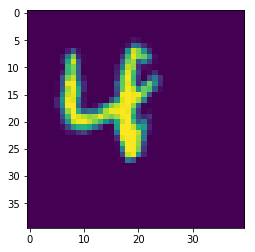

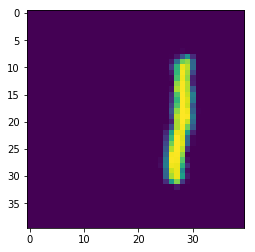

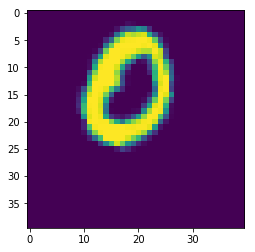

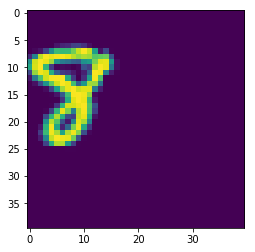

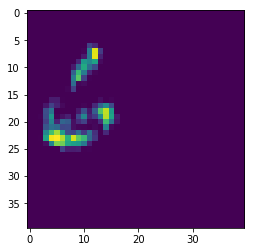

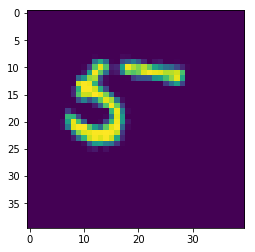

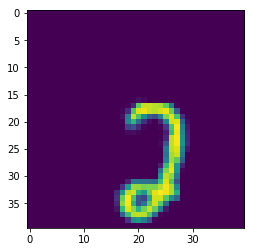

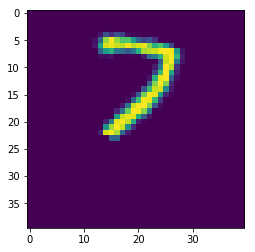

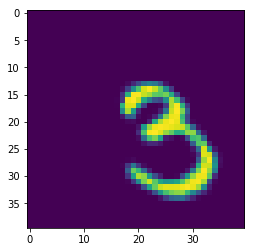

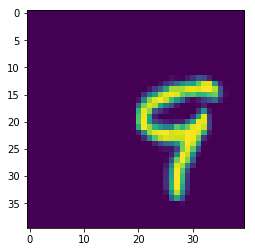

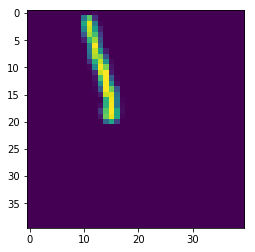

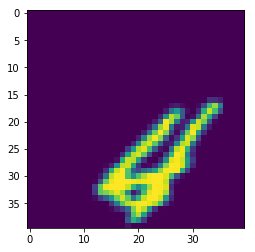

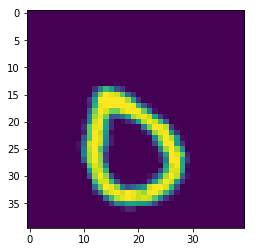

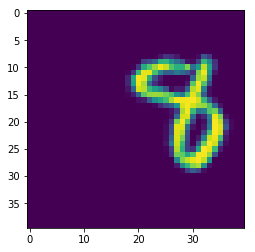

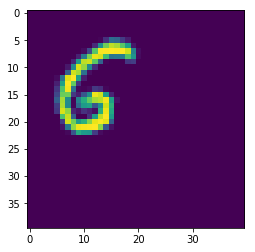

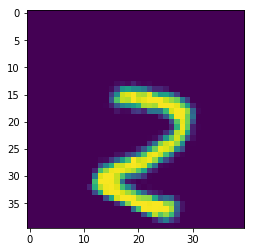

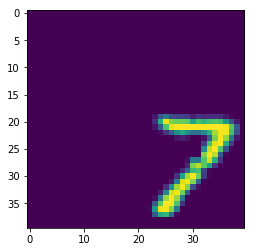

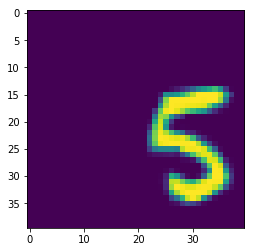

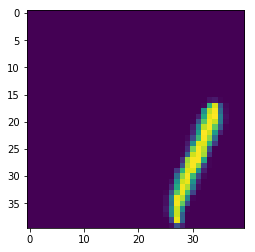

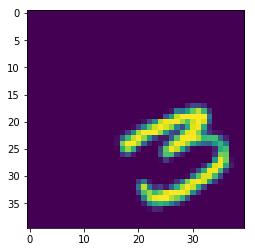

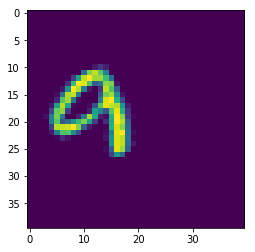

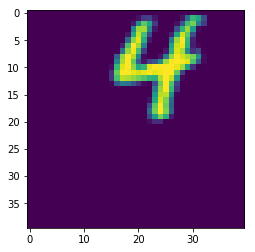

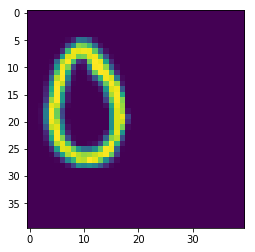

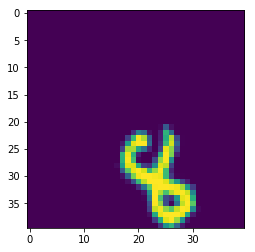

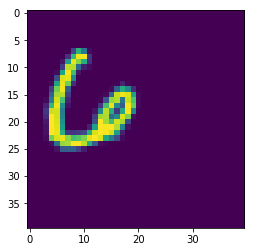

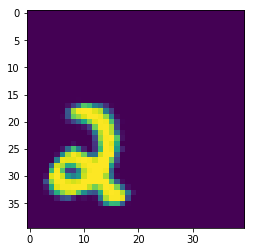

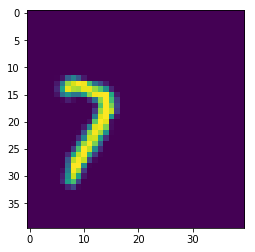

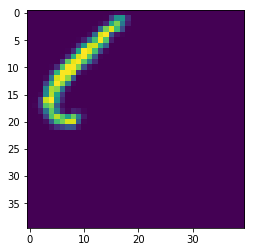

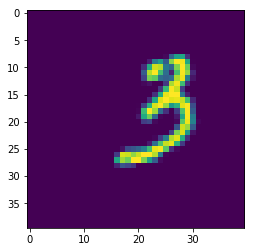

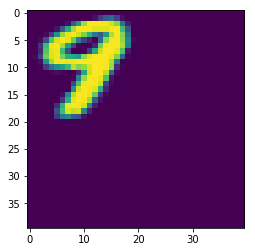

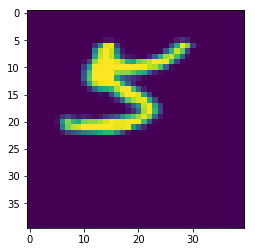

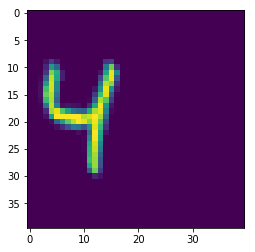

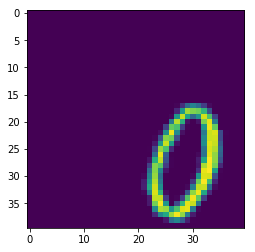

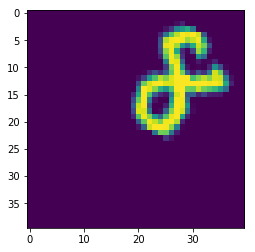

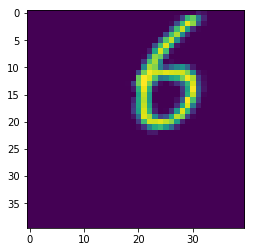

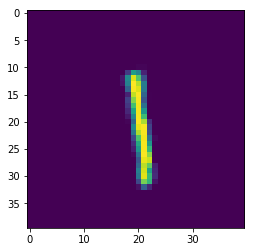

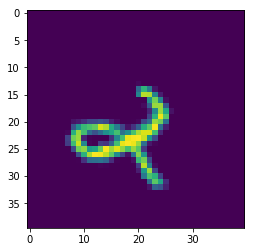

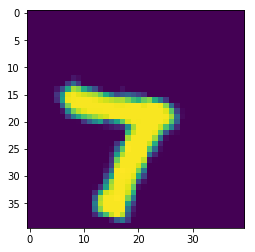

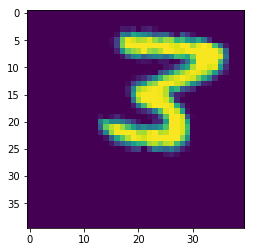

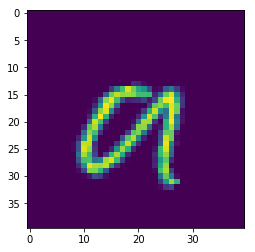

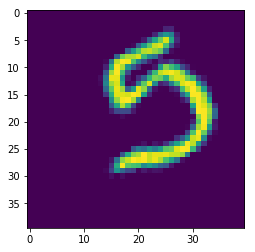

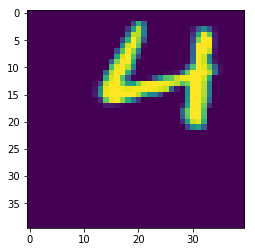

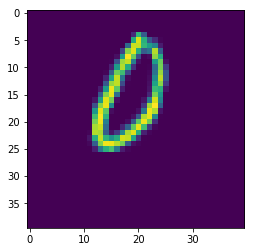

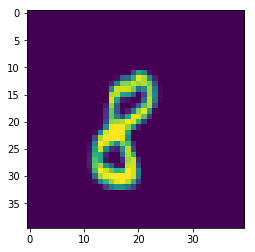

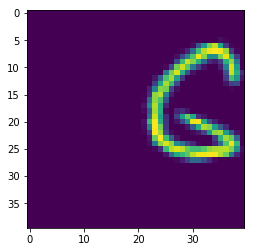

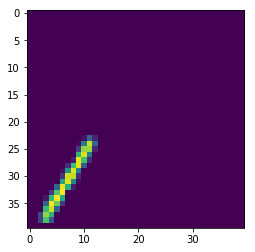

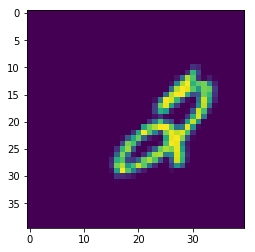

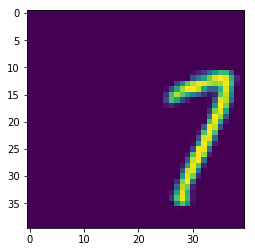

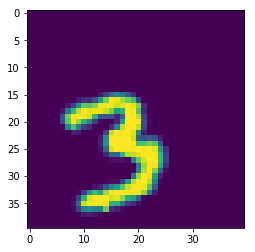

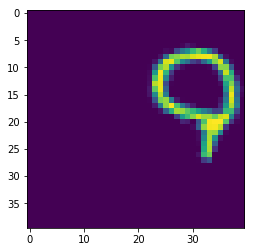

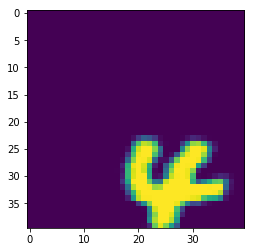

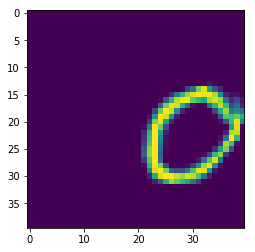

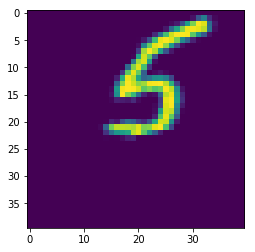

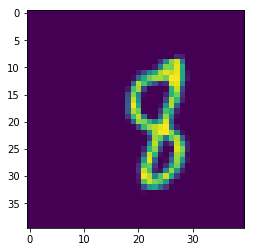

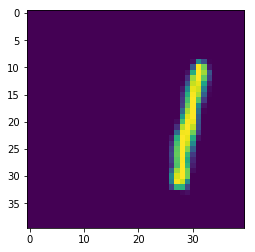

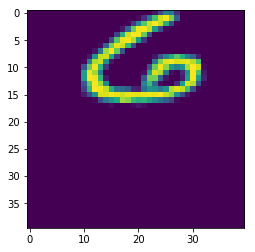

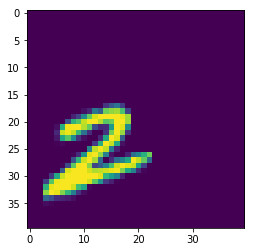

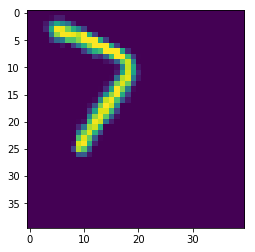

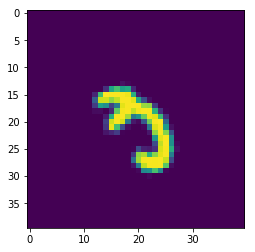

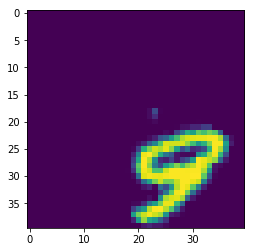

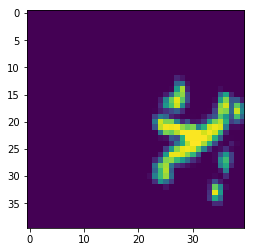

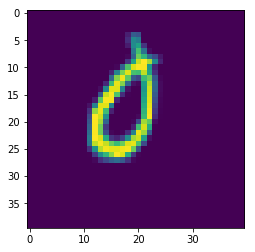

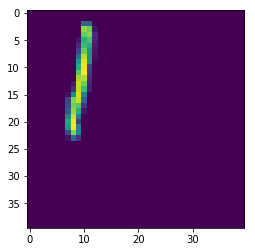

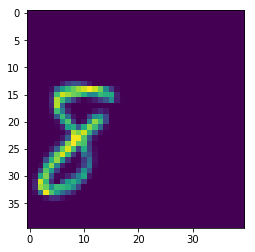

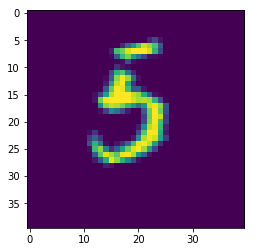

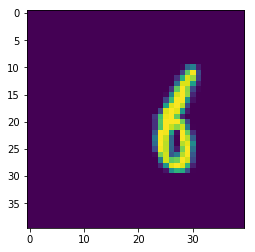

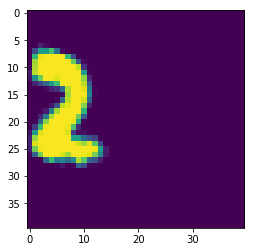

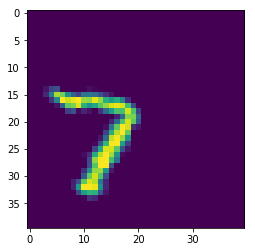

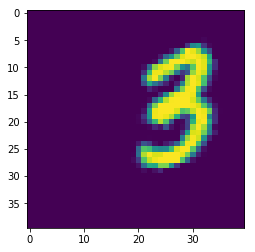

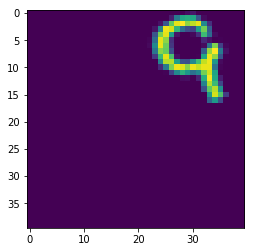

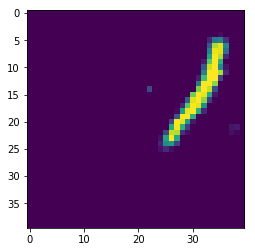

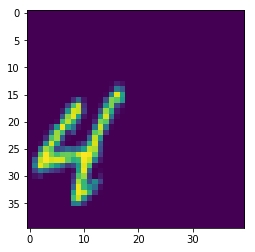

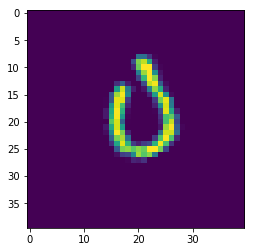

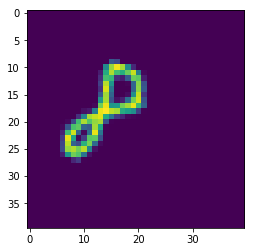

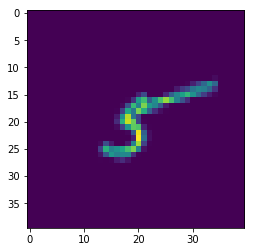

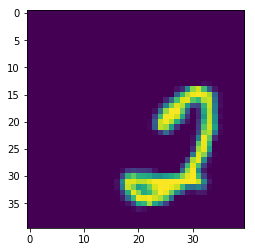

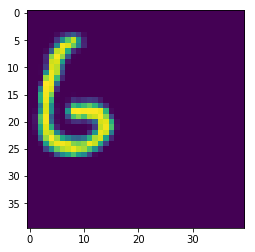

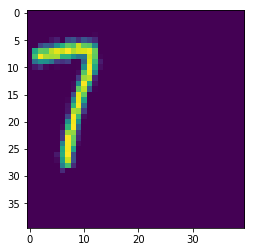

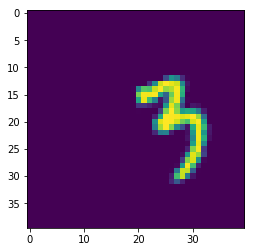

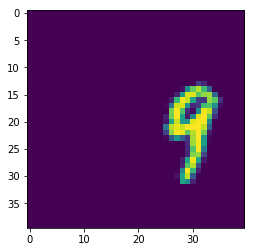

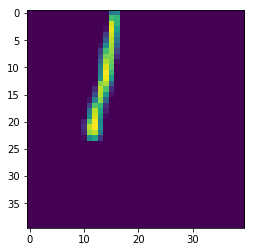

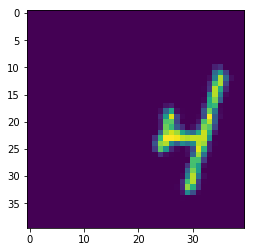

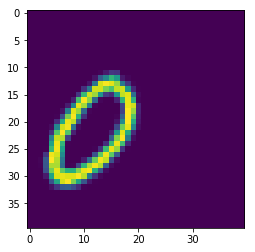

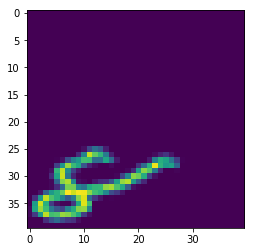

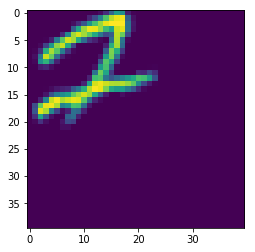

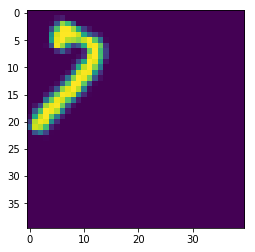

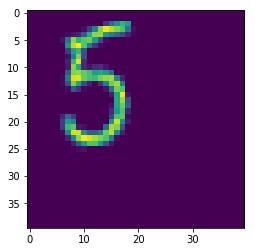

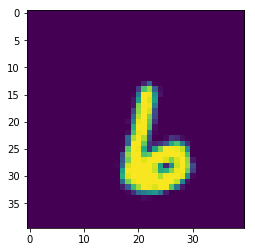

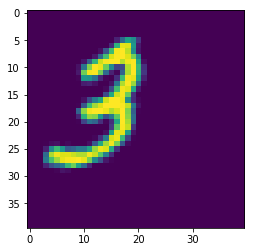

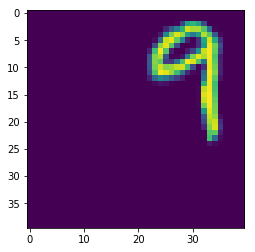

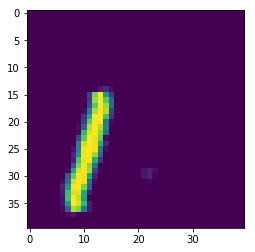

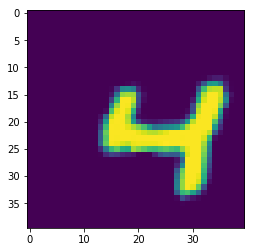

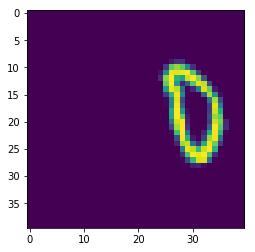

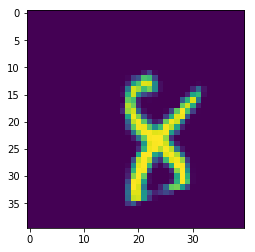

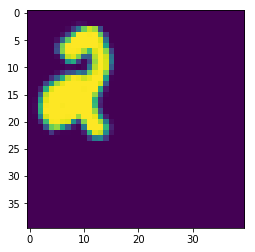

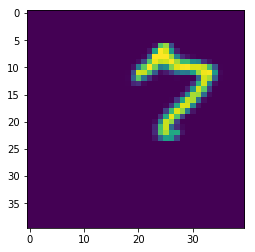

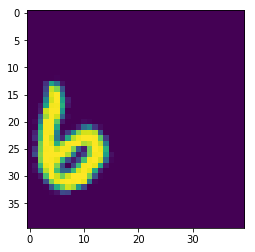

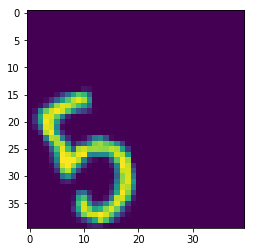

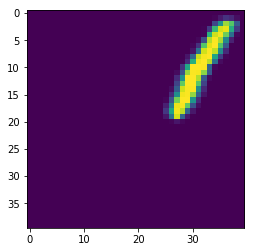

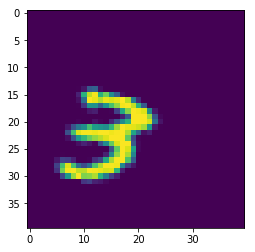

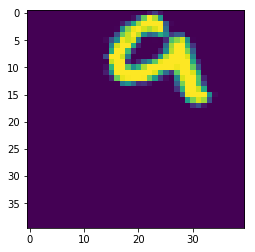

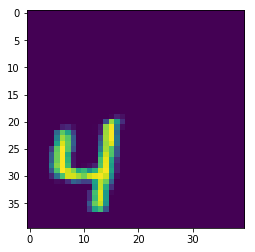

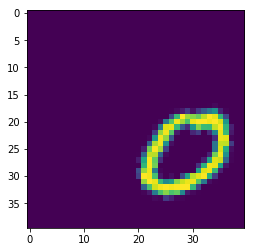

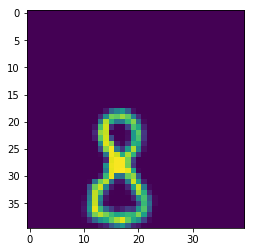

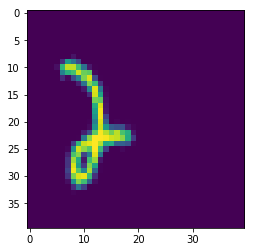

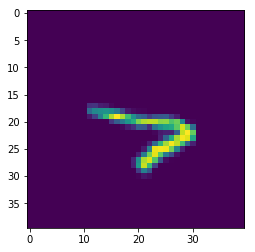

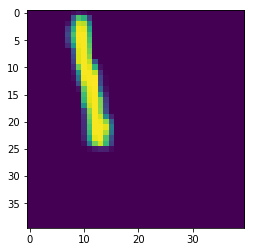

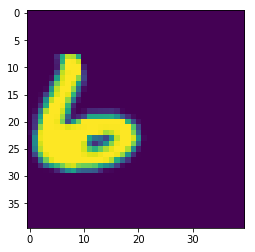

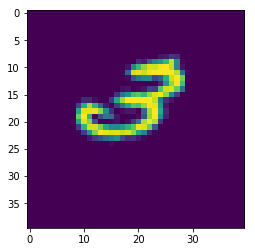

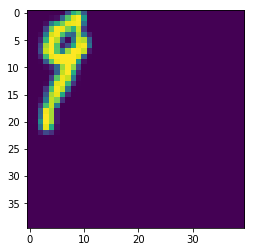

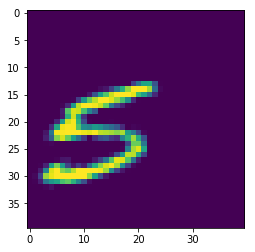

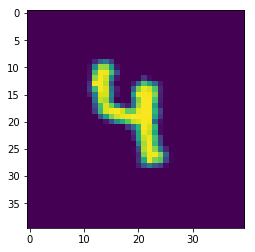

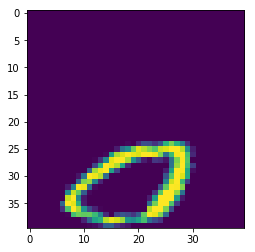

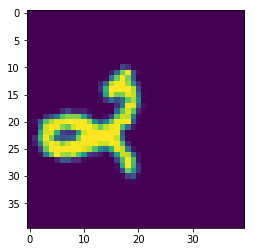

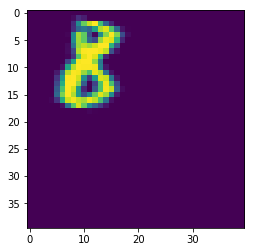

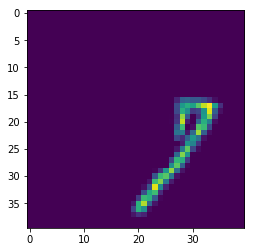

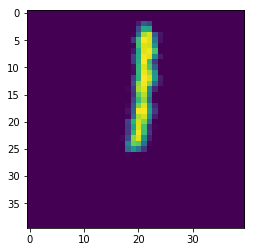

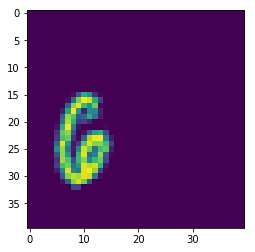

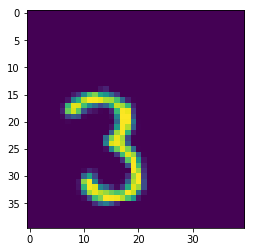

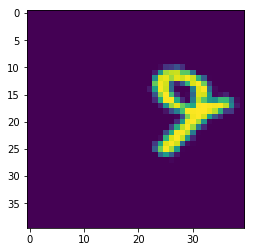

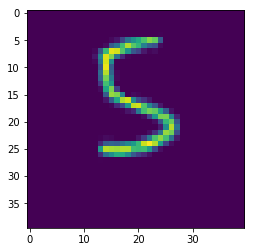

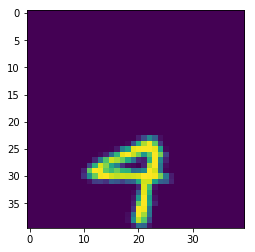

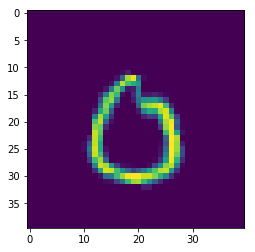

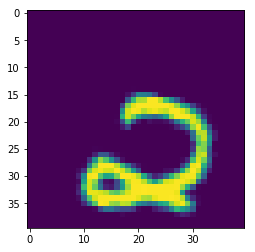

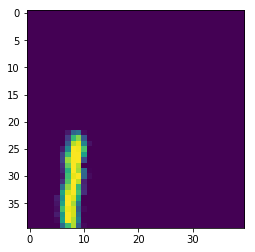

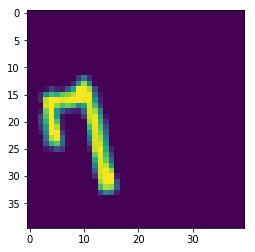

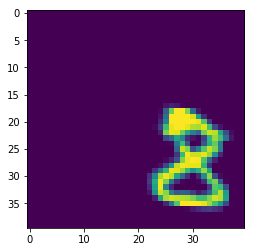

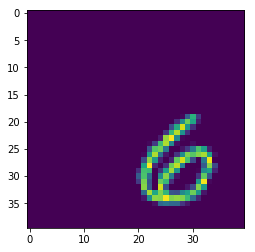

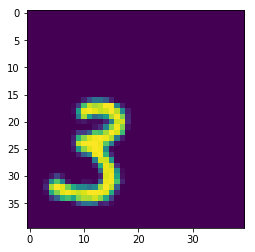

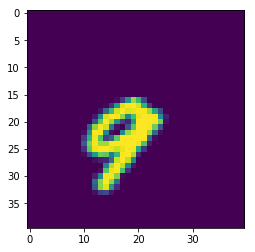

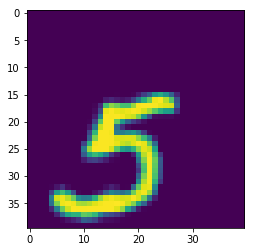

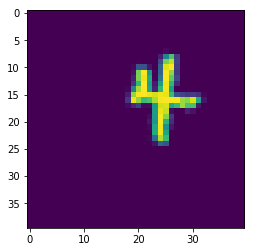

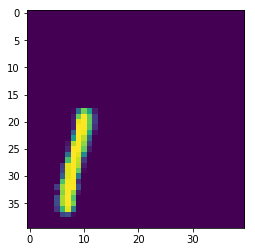

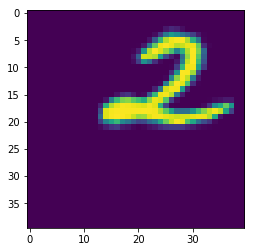

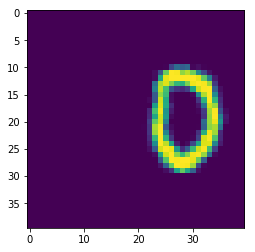

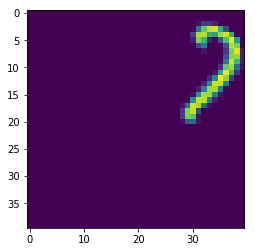

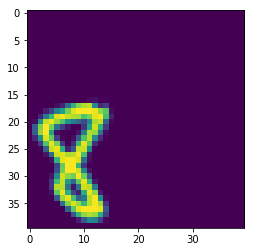

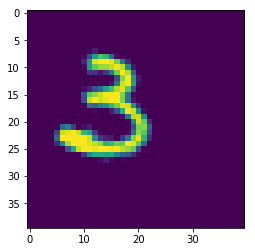

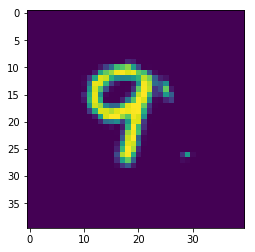

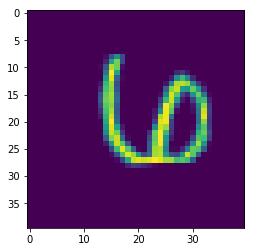

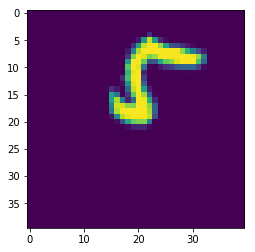

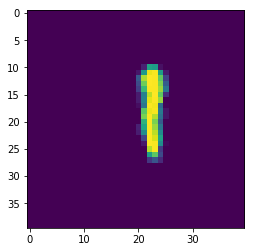

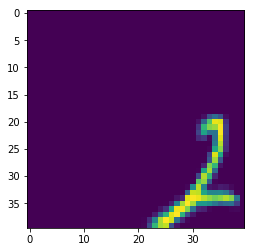

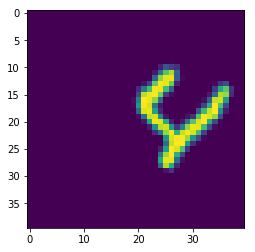

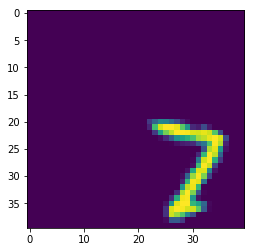

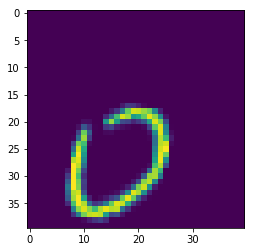

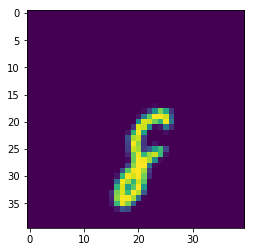

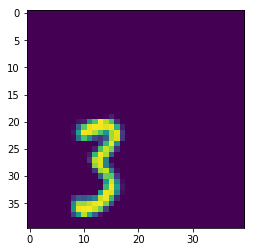

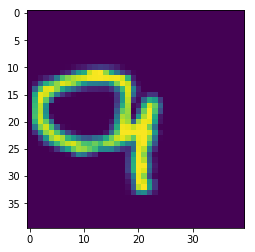

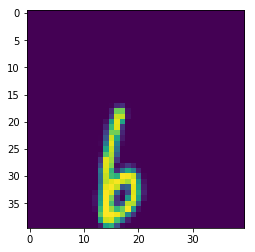

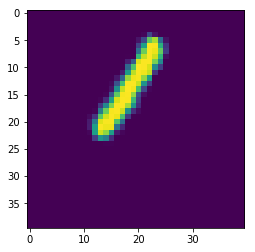

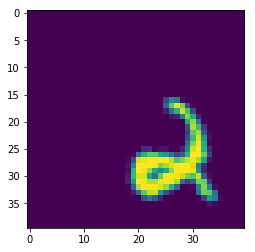

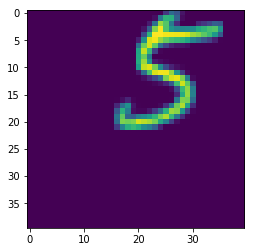

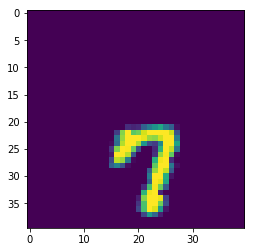

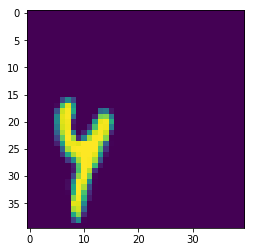

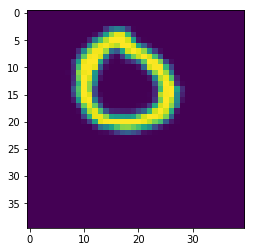

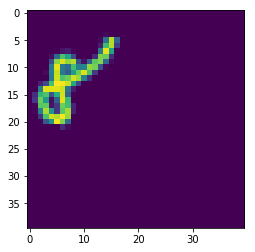

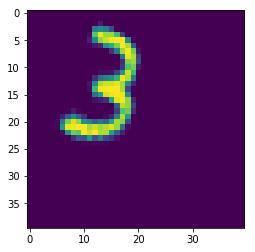

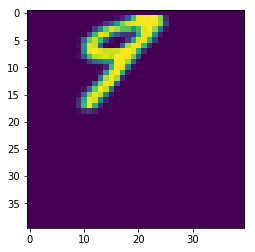

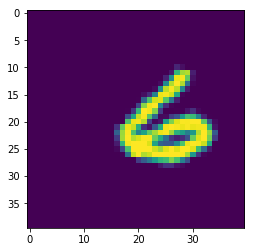

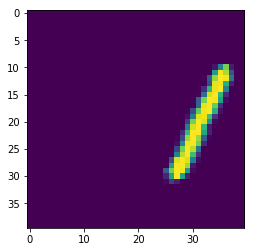

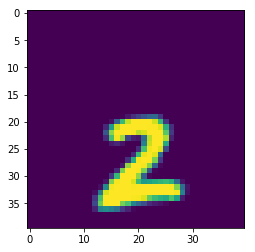

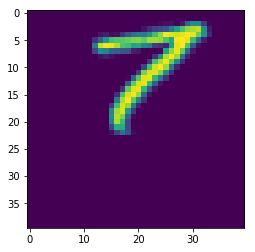

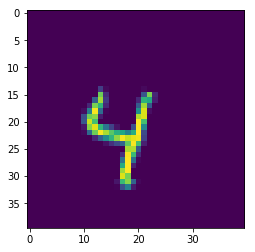

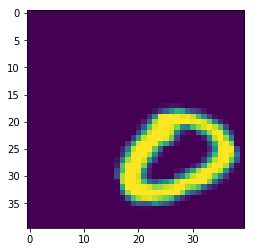

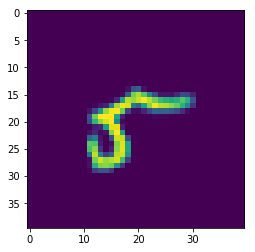

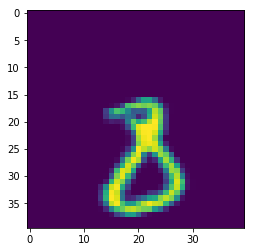

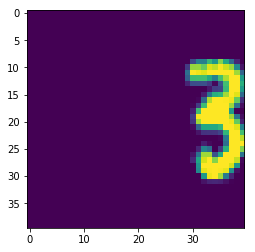

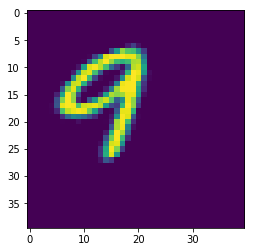

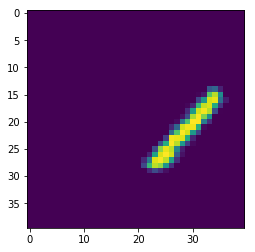

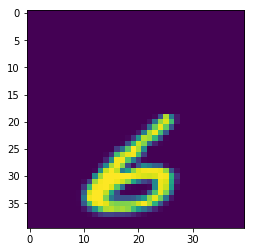

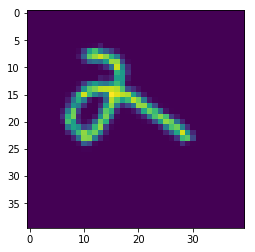

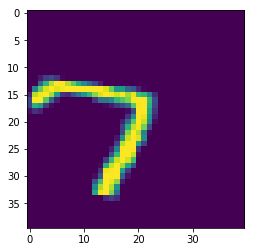

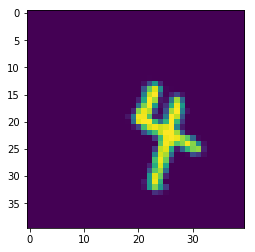

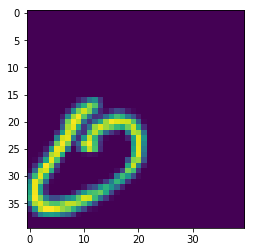

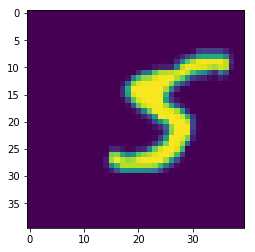

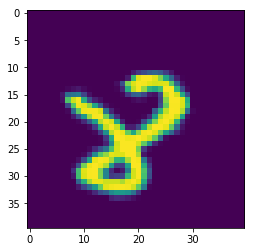

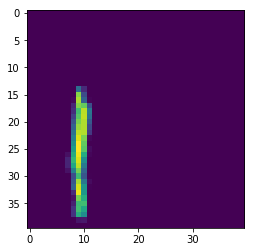

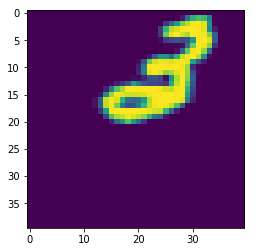

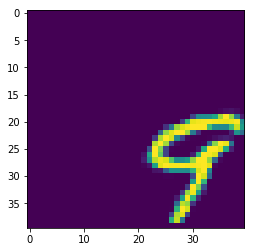

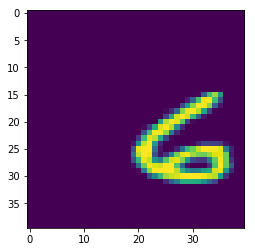

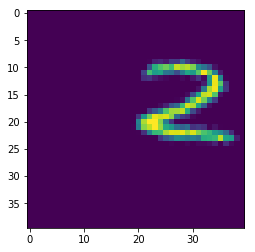

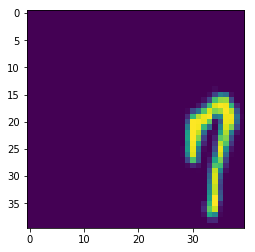

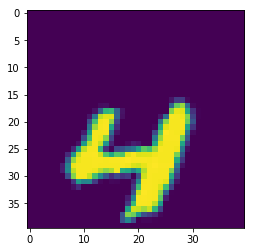

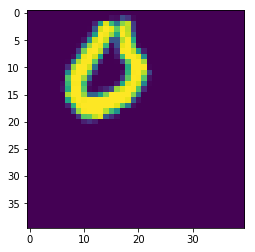

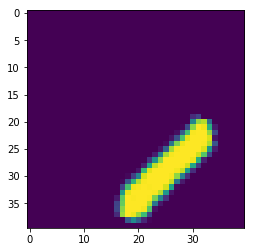

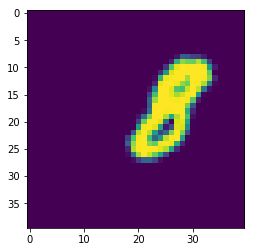

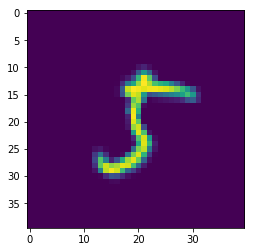

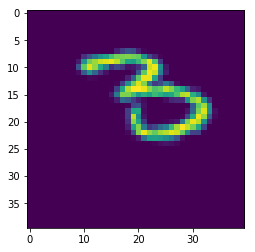

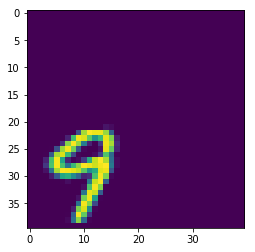

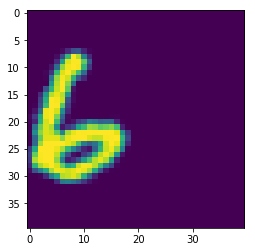

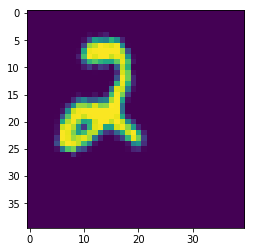

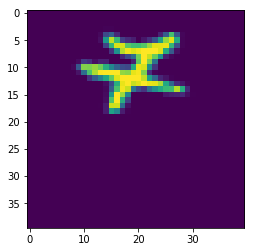

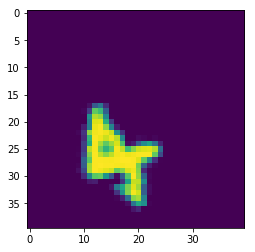

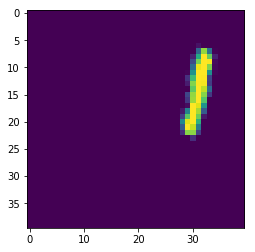

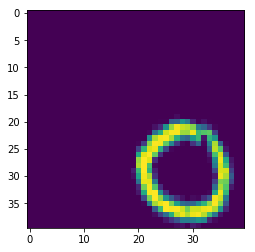

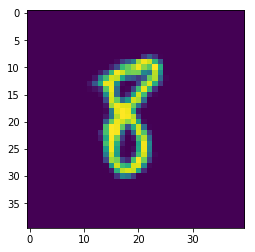

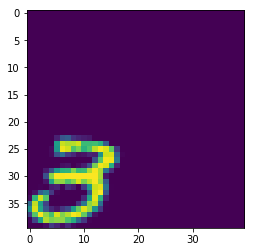

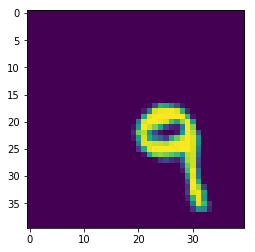

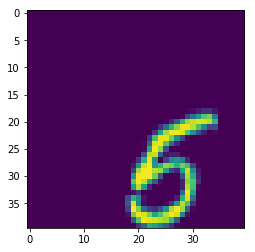

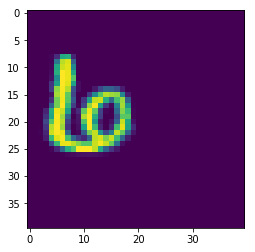

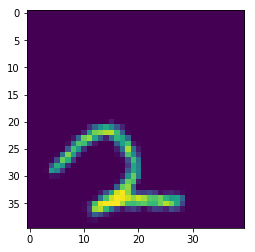

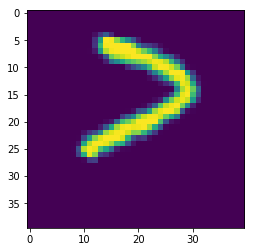

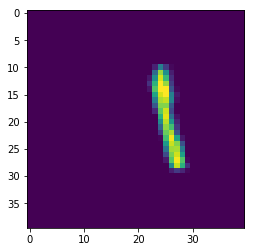

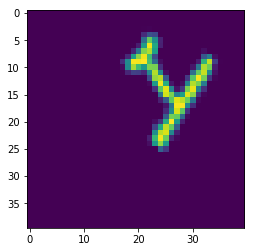

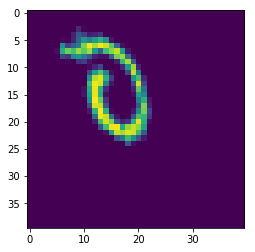

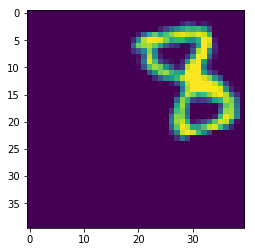

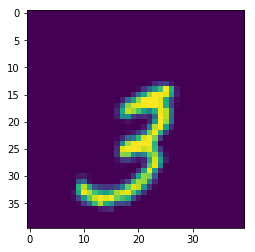

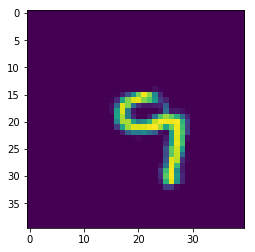

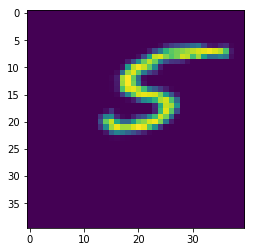

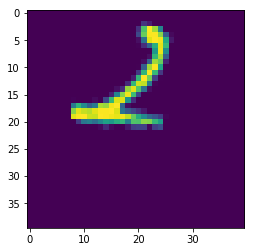

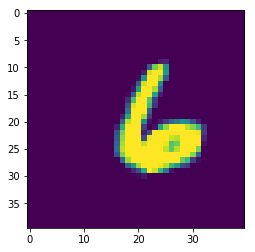

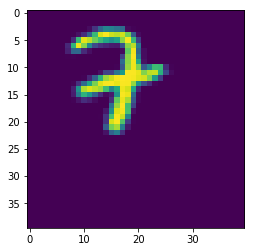

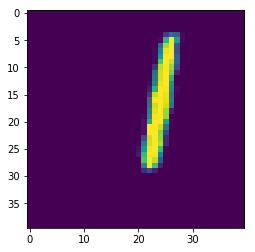

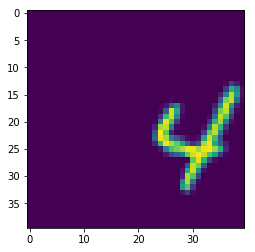

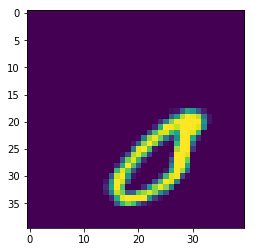

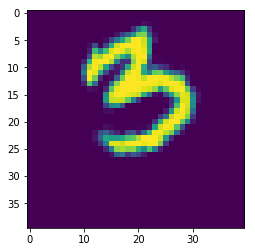

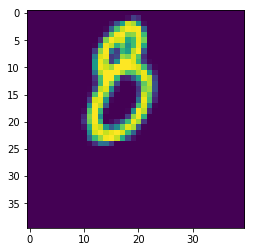

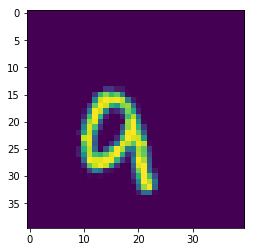

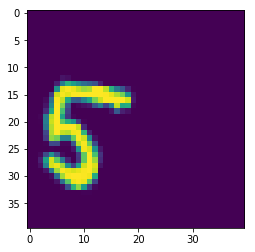

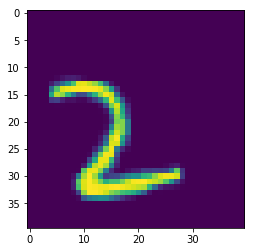

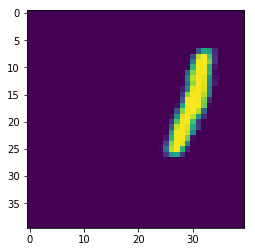

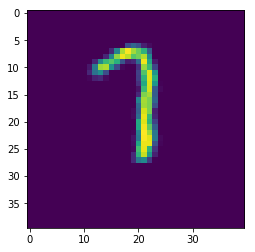

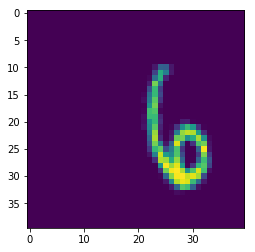

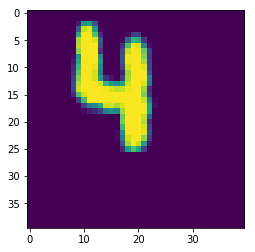

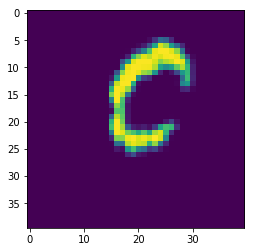

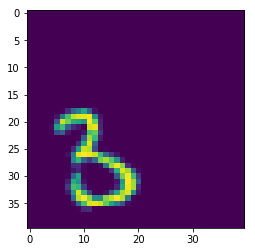

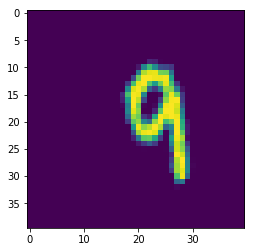

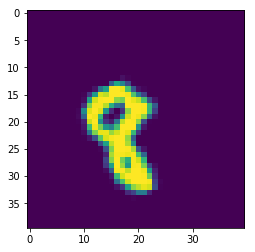

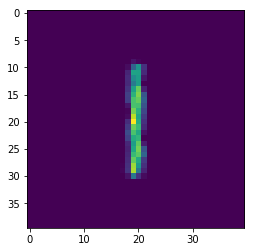

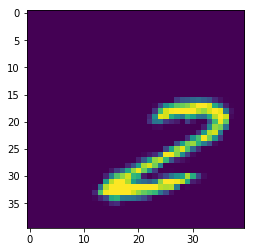

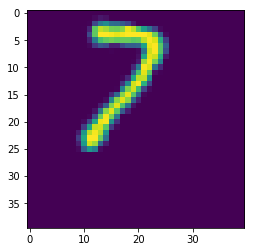

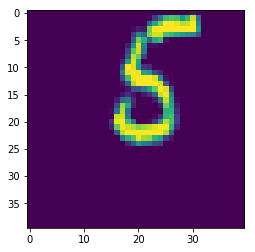

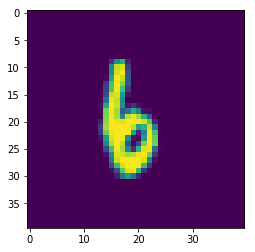

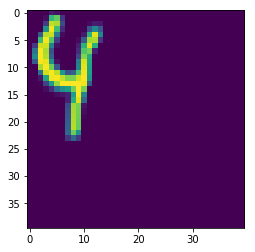

In [3]:
import matplotlib.pyplot  as plt
for i in range(300):
    plt.imshow(np.reshape(x_test[i].astype(np.uint8),(40,40)) )
    plt.show()

In [5]:
xc[i]

array([ 112.,  138.,  141., ...,  117.,  133.,  136.])

In [3]:
# ###########Get generated lable 1 samples by using SMOTE######################
# for j, yj in enumerate(yyy):
#     if yj!=1:
#         yyy[j]=0

# # print(np.size(x_1))
# sm = SMOTE(ratio=0.12376,random_state=42)
# xc,yc = sm.fit_sample(xxx,yyy)
# print('new dataset shape{}'.format(Counter(yc)))

# refined_label = [1]
# train_label1_idx = np.array([], dtype = np.uint8)
# for idx, label_value in enumerate(refined_label):
#     refined_one_label_idx = np.where( yc == label_value )[0][:]
#     train_label1_idx = np.append( train_label1_idx,  refined_one_label_idx)
# x1 = xc[train_label1_idx, :]
# y1 = yc[train_label1_idx]
# print('x1.shape:',x1.shape)
# print('y1.shape:',y1.shape)


###########Get majority samples ##################################
refined_label = [1, 3, 5, 7, 9]
num_train_per_label = [5000, 5000, 5000, 5000, 5000]
train_other_label_idx = np.array([], dtype = np.uint8)
for idx, label_value in enumerate(refined_label):
    refined_one_label_idx = np.where( y == label_value )[0][:]
    train_other_label_idx = np.append( train_other_label_idx,  refined_one_label_idx)
xother = x[train_other_label_idx, :]
yother1 = y[train_other_label_idx]
yother = yother1#[:,0]
print('xother.shape:',xother.shape)
print('yother.shape:',yother.shape)
#print('new dataset shape{}'.format(Counter(yother)))
# img_rows, img_cols = 28, 28
num_classes=10



# if K.image_data_format() == 'channels_first':
#     xx = xc.reshape(xc.shape[0], 1, img_rows, img_cols)
#     x_test1 = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     xx= xc.reshape(xc.shape[0], img_rows, img_cols, 1)
#     x_test1 = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)
    
# if K.image_data_format() == 'channels_first':
#     x1 = x.reshape(x.shape[0], 1, img_rows, img_cols)
#     x_test1 = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x1= x.reshape(x.shape[0], img_rows, img_cols, 1)
#     x_test1 = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)





##################Generate the resampled dataset#######################
 
xres= np.append(xminor,xother,axis=0)
#xres = np.reshape(xre,(49995,40,40))
yres= np.append(yminor,yother,axis=0)
#x_test = np.reshape(xre,(320000,40,40))
print('x_train shape:', xres.shape)
print('x_test shape:', x_test.shape)
print(xres.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')  
print(yres.shape[0], 'yres samples')

y = keras.utils.to_categorical(y, num_classes)
yres = keras.utils.to_categorical(yres, num_classes)
#yy = keras.utils.to_categorical(yc, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same',
#                  input_shape=(None,1,40,40)))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))
model.add(Dense(128,activation='relu',input_dim=1600))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.summary()
#loss=keras.losses.categorical_crossentropy,
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(xres, yres, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

xother.shape: (25000, 1600)
yother.shape: (25000,)
x_train shape: (49995, 1600)
x_test shape: (320000, 1600)
49995 train samples
320000 test samples
49995 yres samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 276,106
Trainable params: 276,106
Non-trainable params: 0
_________________________________________________________________
Train on 49995 samples, validate on 320000 samples
Epoch 1/50
49995/49995 [=========================

In [5]:
yother.shape

(25000, 1)

In [3]:
len(yc)

11846

In [4]:
import matplotlib.pyplot  as plt

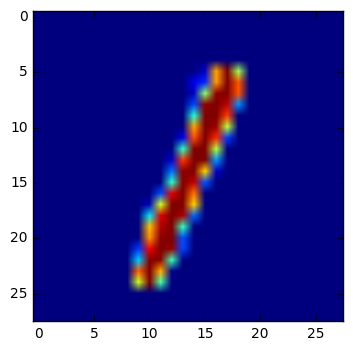

In [9]:
plt.imshow(np.reshape(xc[11833],(28,28)) )
plt.show()

In [18]:
np.squeeze(xx[1,:,:,:])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    

In [19]:
xx[1,:,:,:]

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [